In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
#import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

myubatch_size = 32768

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class ALLINPUTNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(ALLINPUTNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim = -1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2, dim = 1)
        return torch.mean(torch.sqrt(mseloss))   

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2)       

    def y_proc(y):
        MS = y[:,1] * y[:,0]
        IR = y[:,1] ** 2 +  y[:,0] ** 2
        return torch.vstack((MS,IR)).T
    

    def fastbatchtrain(self, x, y, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        
        y_proc = torch.tensor(ALLINPUTNET.y_proc(torch.tensor(y, dtype = torch.float64).to(device)), dtype = torch.float64).to(device)

        dataloader = DataLoader(dataset = torch.hstack((x,y_proc)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    
                    loss = self.msef(ALLINPUTNET.y_proc(y_pred),U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L

In [4]:
class ALLINPUTPINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(ALLINPUTPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        self._Wtmx.register_parameter('myu', myu)
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,x):
        myuloss = MYULOSS(*tuple(x.T),self)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE

In [5]:
class MYULOSS:
  def __init__(self, x, y, t, net, verbose = 0):
      self.msef = nn.MSELoss()
      self.FMSE = []
      self.x = x
      self.y = y
      self.t = t
      self.net = net
        
  def plot(self, title= 'MYU training'):
    plt.plot(self.FMSE)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('FMSE')
    self.clear()
    
  def clear(self):
    self.FMSE = []
    
  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss
  
  def net_f(self, myu, verbose = 0):
        return self.f_withoutmyu - myu*self.u 
    
  def calculate_f_withoutmyu(self):
        x,y,t = self.x, self.y, self.t
        
        u, u_t,u_xx,u_yy = MYULOSS.pref(x,y,t,net)
        
        self.u = u.cpu().detach()
            
        f_withoutmyu = u_t - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u #- myu*u
        self.f_withoutmyu = f_withoutmyu.cpu().detach()
        free_memory(u_t, u_xx, u_yy, u, f_withoutmyu)

    
  def f_withoutmyu(x,y,t,ru,iu):
        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j)
        u_t = (ru_t + iu_t * 1j)
        u_xx =( ru_xx + iu_xx *1j)
        u_yy = (ru_yy + iu_yy *1j)
        
        return u, u_t,u_xx,u_yy
    
  def pref(x,y,t, net, batch_size = myubatch_size):
    dataloader = DataLoader(dataset = X_star, batch_size = batch_size, shuffle=False)
    cache = {
        'u':[],
        'u_t':[],
        'u_xx':[],
        'u_yy':[],
    }
    for tmp in tqdm(dataloader):
        x,y,t = torch.tensor(tmp.T, dtype = torch.float64, requires_grad=True).to(device)
        ru,iu = net.forward(torch.stack((x,y,t)).T).T
        u, u_t,u_xx,u_yy = MYULOSS.f_withoutmyu(x,y,t,ru,iu)
        cache['u'].append(u.cpu().detach())
        cache['u_t'].append(u_t.cpu().detach())
        cache['u_xx'].append(u_xx.cpu().detach())
        cache['u_yy'].append(u_yy.cpu().detach())
        
    return  torch.cat(cache['u']).view(mem_rate, Nx, Ny), \
            torch.cat(cache['u_t']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_xx']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_yy']).view(mem_rate, Nx, Ny)

      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [6]:
def plot():
    ploter = Plotter(net.myu.cpu().detach().numpy())
    ploter.output_animation(mem_rate, save_gif=True, file_name=rf"{path}_myupred.gif")
    plt.show()
    ploter = Plotter(myu_original.squeeze(0))
    ploter.output_animation(mem_rate, save_gif=True, file_name=rf"{path}_myuorig.gif")
    plt.show()

    create_gifs(
        memory_rate=mem_rate,
        u_pred=net.predict(X_star),
        original=A_original,
        save=True,
        path_for_gif=path+".gif",
        duration=500,
        title=" "
    )
    Image(filename=path+".gif")
    gif = imageio.mimread(path+".gif", memtest=False)
    nums = len(gif)
    print("Total {} frames in the gif {}!".format(nums, path+".gif"))
    

In [7]:
def train():
    L1 = net.fastbatchtrain(x = X_star, y = u_star, epochs = 100000)

    plt.plot(L1)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Custom Loss')
    plt.title('Training of the AllInputNet \n lr=0.01')
    plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')
    plt.show()

    net.optimizer.param_groups[0]['lr'] = 0.001
    L2 = net.fastbatchtrain(x = X_star, y = u_star, epochs = 100000)

    plt.plot(L2)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Custom Loss')
    plt.title('Training of the AllInputNet \n lr=0.001')
    plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')
    plt.show()

In [8]:
def myutrain():
    global device
    global net
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    net.loaddata_precalculate(X_star)
    net.myureset()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    net.myureset()

    i = 0
    for lr in [10, 3, 1, 0.3]:
        L = net.myutrain(lr=lr, epochs=10)
        l = net.fmse().cpu().detach().numpy()
        L += [l]
        net.myuloss.clear()

        plt.plot(range(i,i+len(L)), L, label=f'lr={lr}')
        i+=len(L)-1

    plt.yscale('log')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('FMSE')
    plt.title('MYU Training')
    plt.tight_layout()
    plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
    plt.show()

In [9]:
!mkdir -p main_lossanalysis
import pandas as pd
df = pd.DataFrame({"key":[],"N":[],"L":[],"mse":[],"rmse":[], "fmse": []})

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:00<00:00, 9482.24it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
A.shape=(1, 800, 4, 4),
Myu.shape=(1, 800, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████| 100000/100000 [02:08<00:00, 776.92it/s]


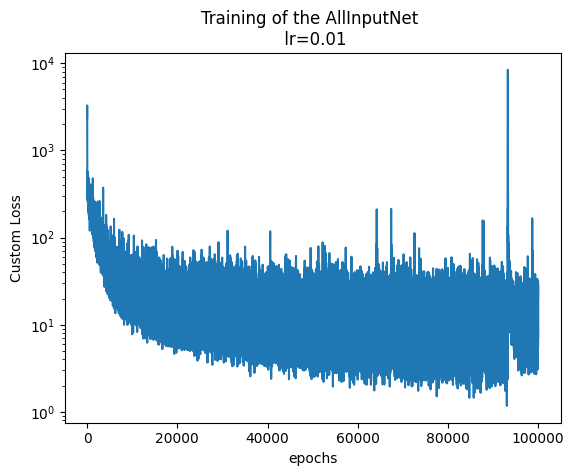

100%|██████████| 100000/100000 [02:04<00:00, 804.03it/s]


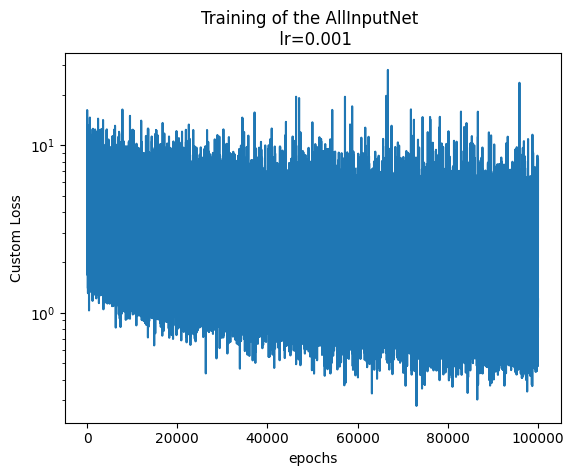

100%|██████████| 10/10 [00:00<00:00, 1030.41it/s]


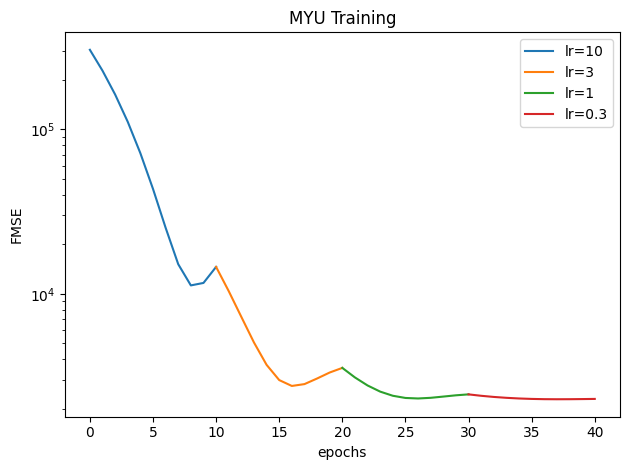

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

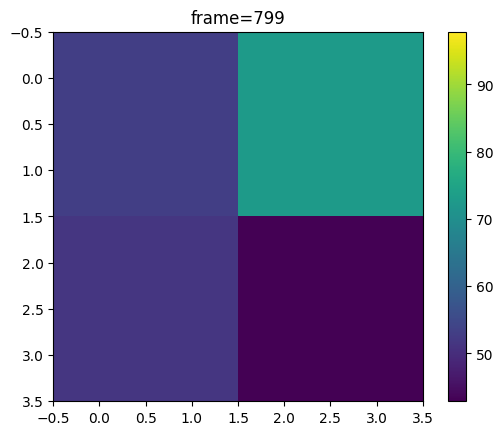

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

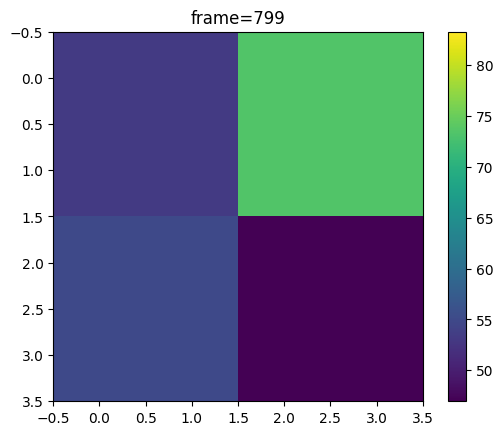

100%|██████████| 800/800 [00:45<00:00, 17.42it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=4L=10-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=4L=10-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 9826.18it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
A.shape=(1, 800, 4, 4),
Myu.shape=(1, 800, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████| 100000/100000 [02:01<00:00, 826.12it/s]


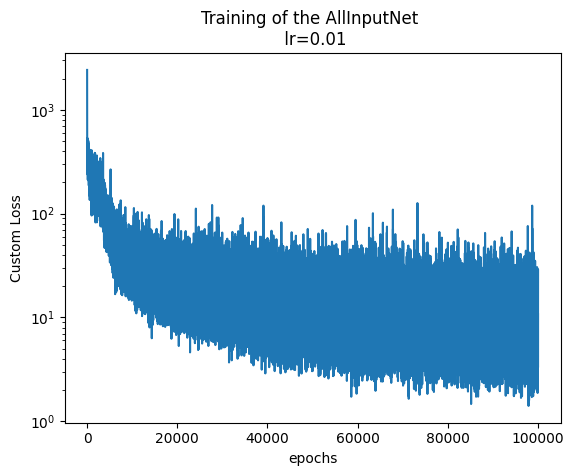

100%|██████████| 100000/100000 [02:02<00:00, 815.29it/s]


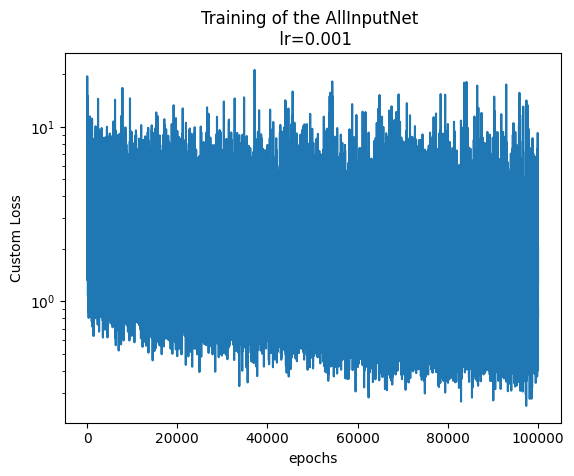

100%|██████████| 10/10 [00:00<00:00, 1557.14it/s]


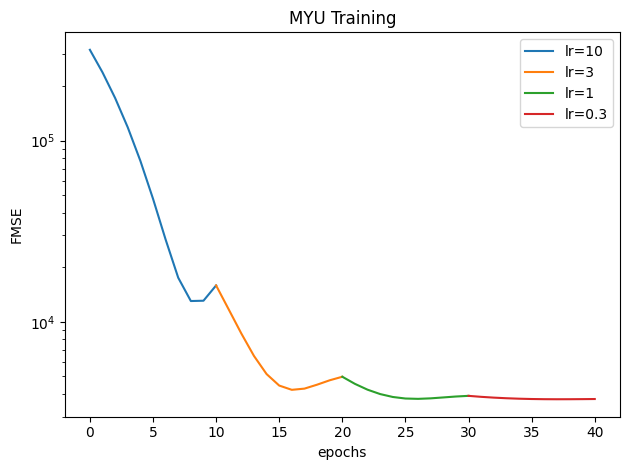

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

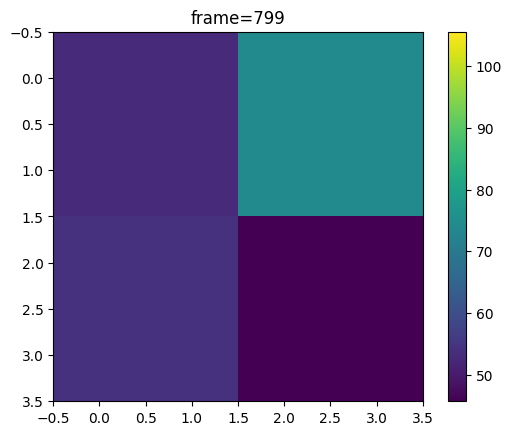

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

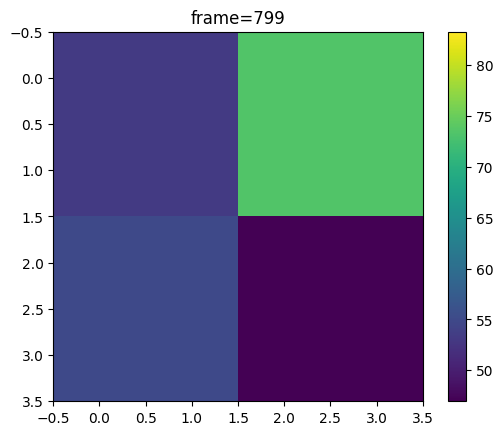

100%|██████████| 800/800 [00:45<00:00, 17.60it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=4L=20-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=4L=20-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 9841.19it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
A.shape=(1, 800, 4, 4),
Myu.shape=(1, 800, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████| 100000/100000 [02:01<00:00, 826.15it/s]


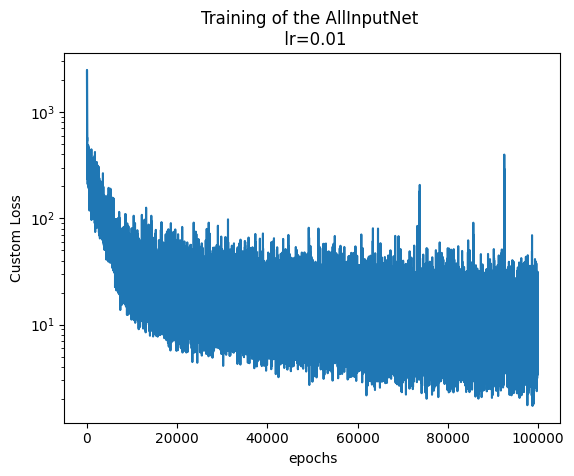

100%|██████████| 100000/100000 [02:45<00:00, 604.99it/s]


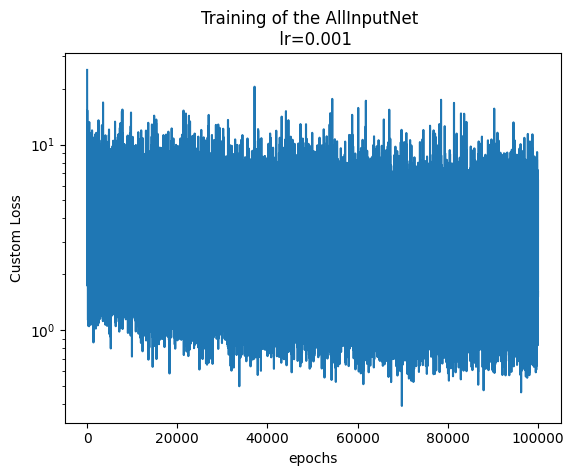

100%|██████████| 10/10 [00:00<00:00, 745.77it/s]


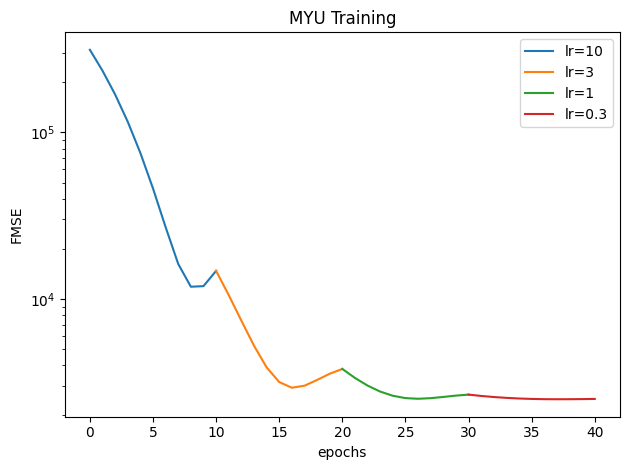

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

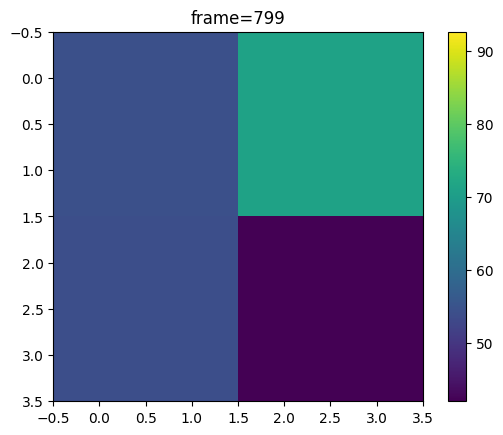

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

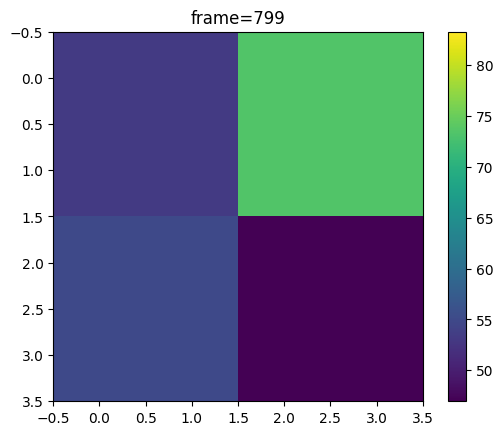

100%|██████████| 800/800 [00:45<00:00, 17.39it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=4L=30-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=4L=30-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 9904.52it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
A.shape=(1, 800, 4, 4),
Myu.shape=(1, 800, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████| 100000/100000 [01:57<00:00, 853.14it/s]


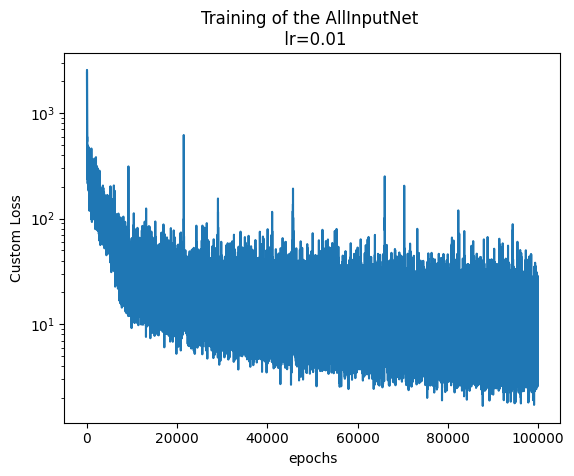

100%|██████████| 100000/100000 [01:57<00:00, 854.42it/s]


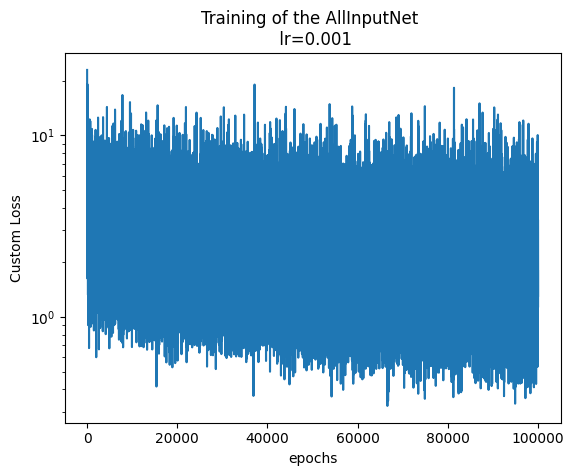

100%|██████████| 10/10 [00:00<00:00, 1779.36it/s]


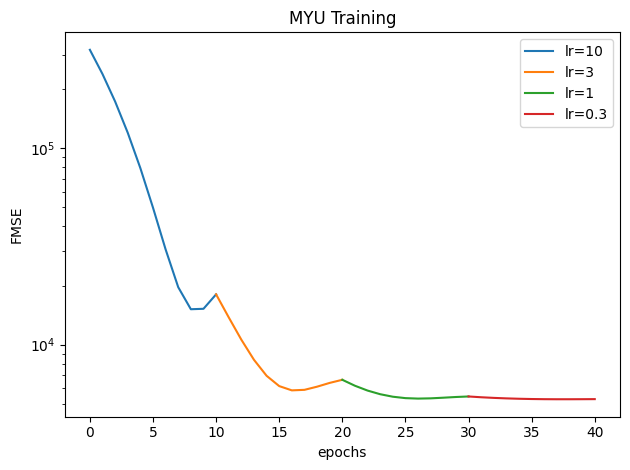

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

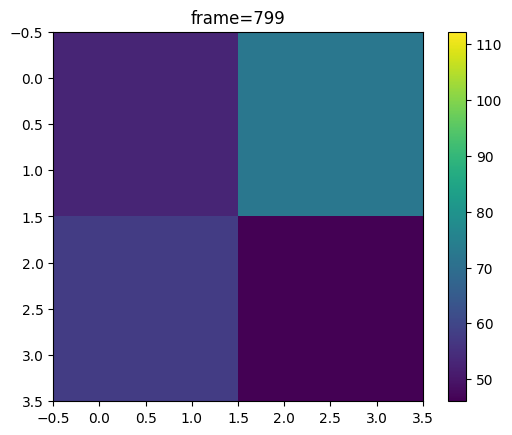

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

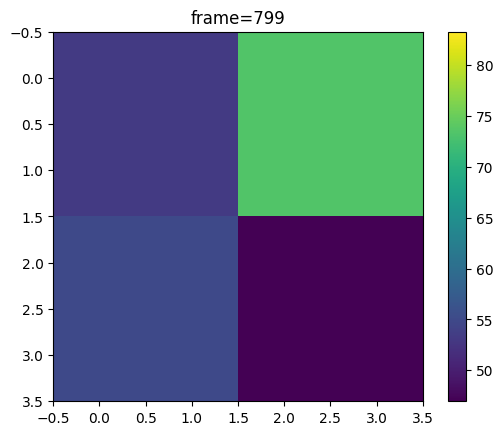

100%|██████████| 800/800 [00:45<00:00, 17.67it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=4L=40-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=4L=40-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8969.52it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500]
A.shape=(1, 800, 10, 10),
Myu.shape=(1, 800, 10, 10),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:57<00:00, 848.05it/s]


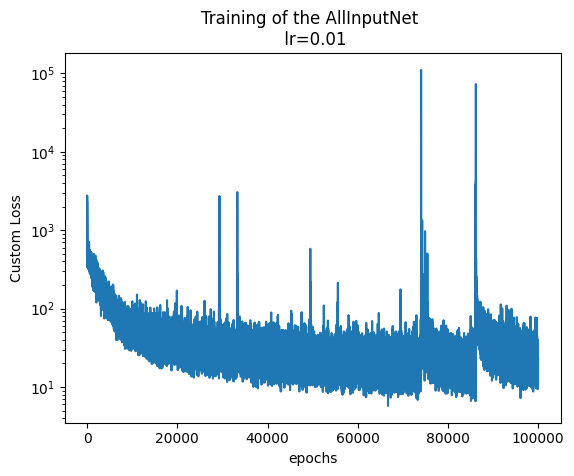

100%|██████████| 100000/100000 [01:57<00:00, 849.47it/s]


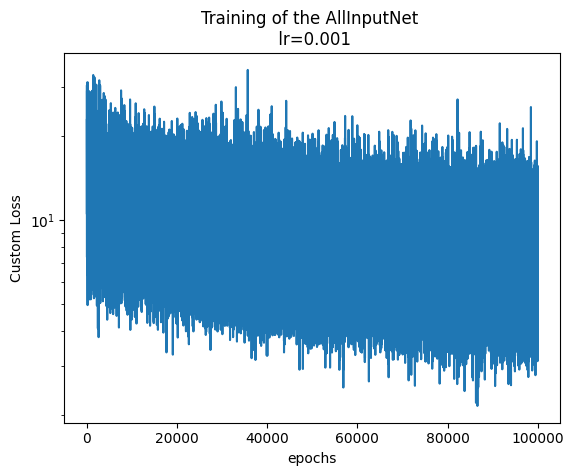

100%|██████████| 10/10 [00:00<00:00, 516.85it/s]


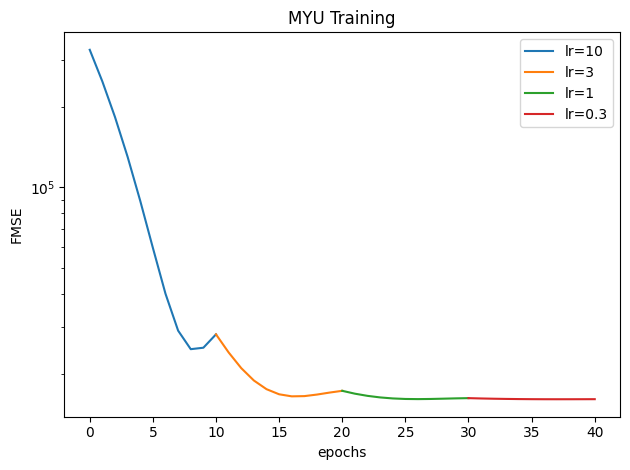

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

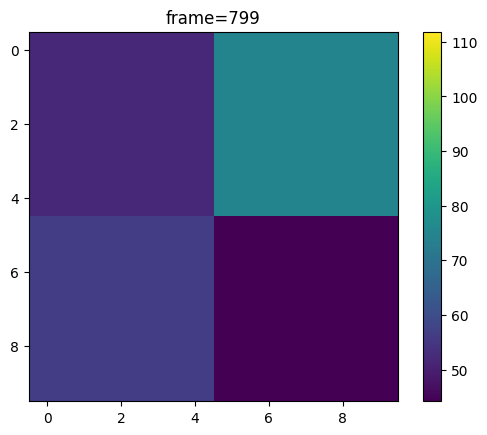

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

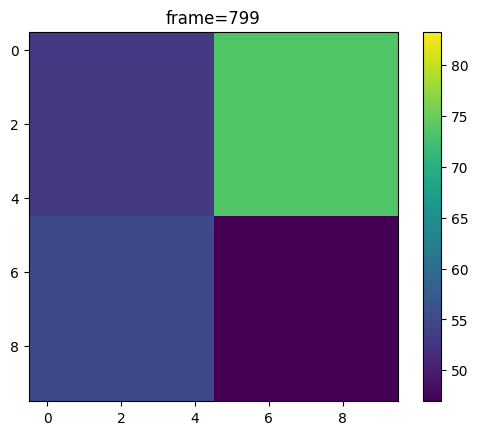

100%|██████████| 800/800 [00:40<00:00, 19.83it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=10L=10-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=10L=10-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8966.93it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500]
A.shape=(1, 800, 10, 10),
Myu.shape=(1, 800, 10, 10),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:57<00:00, 848.45it/s]


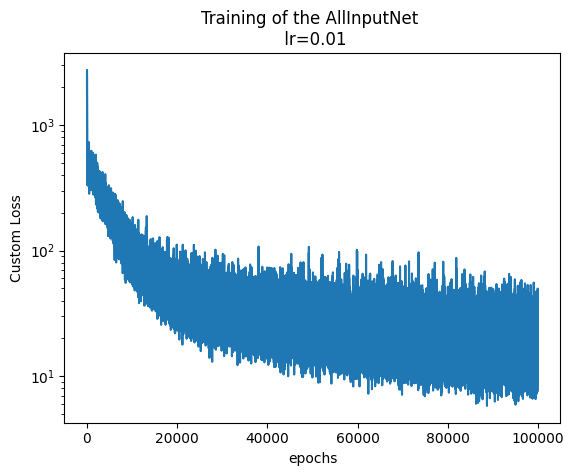

100%|██████████| 100000/100000 [02:05<00:00, 798.30it/s]


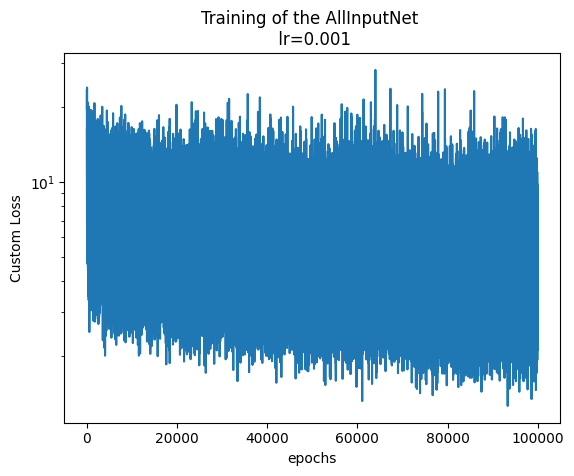

100%|██████████| 10/10 [00:00<00:00, 384.77it/s]


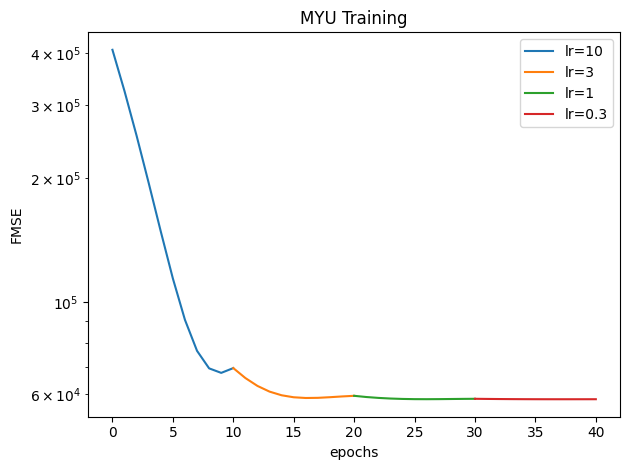

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

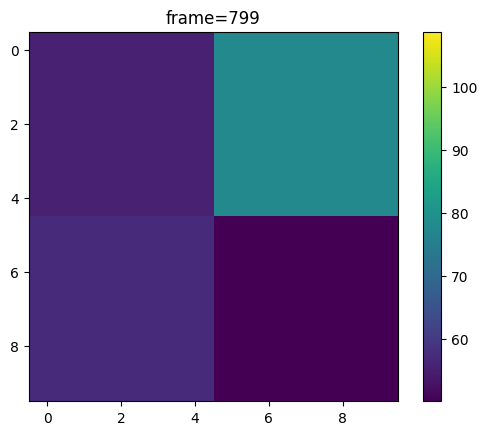

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

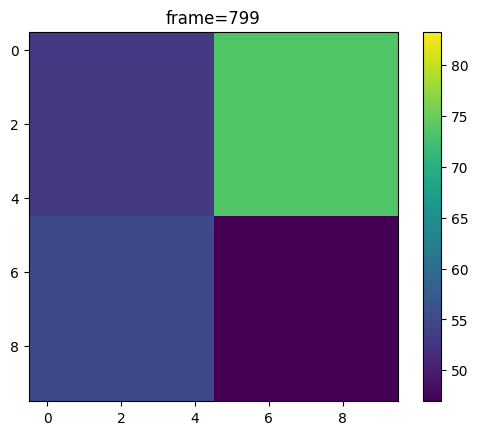

100%|██████████| 800/800 [00:39<00:00, 20.05it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=10L=20-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=10L=20-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 9108.30it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500]
A.shape=(1, 800, 10, 10),
Myu.shape=(1, 800, 10, 10),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [02:11<00:00, 761.47it/s]


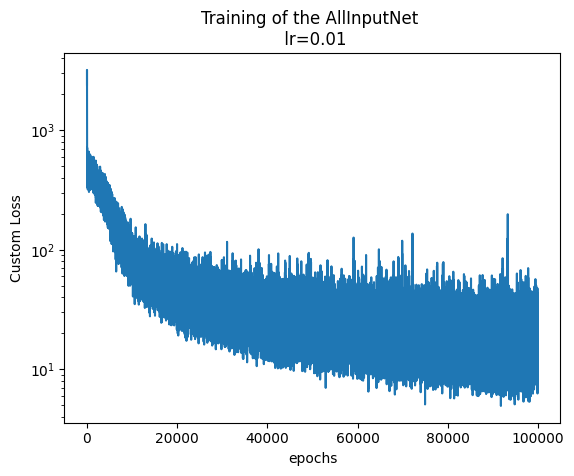

100%|██████████| 100000/100000 [02:02<00:00, 816.64it/s]


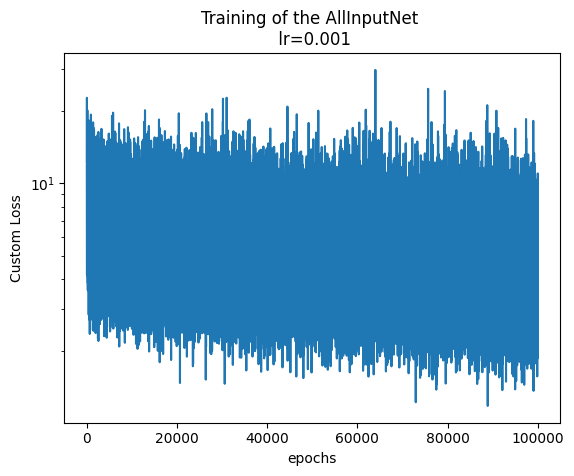

100%|██████████| 10/10 [00:00<00:00, 295.69it/s]


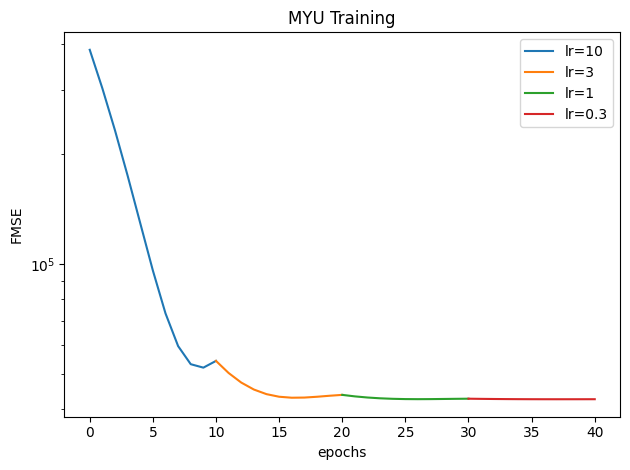

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

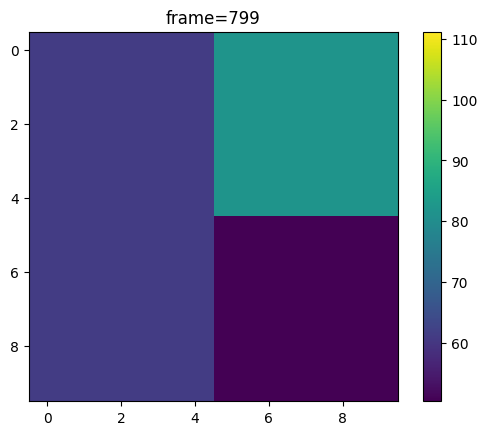

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

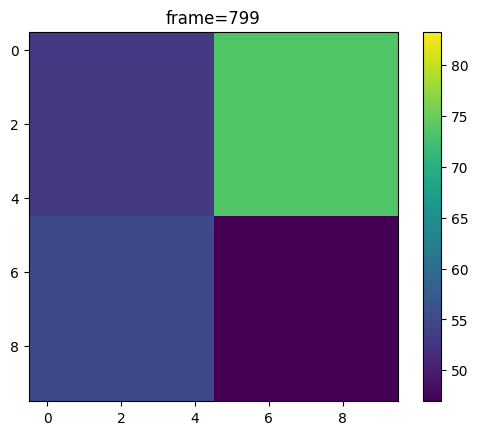

100%|██████████| 800/800 [00:40<00:00, 19.95it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=10L=30-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=10L=30-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8962.48it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500]
A.shape=(1, 800, 10, 10),
Myu.shape=(1, 800, 10, 10),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:57<00:00, 847.97it/s]


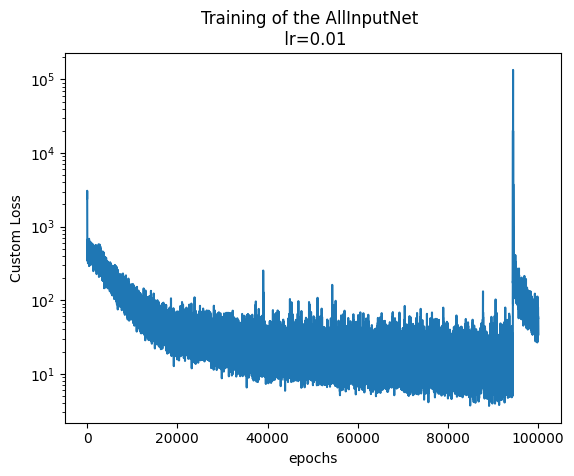

100%|██████████| 100000/100000 [01:58<00:00, 842.24it/s]


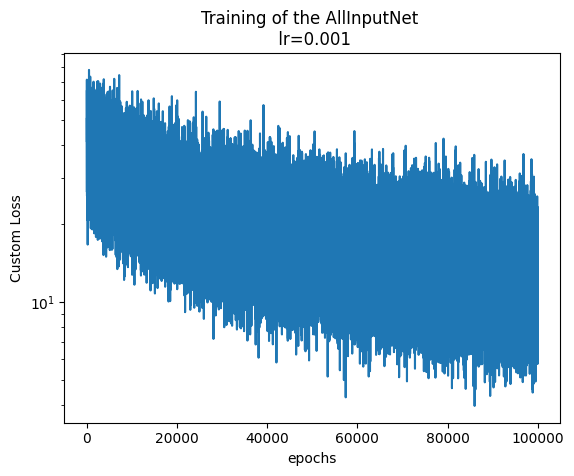

100%|██████████| 10/10 [00:00<00:00, 642.75it/s]


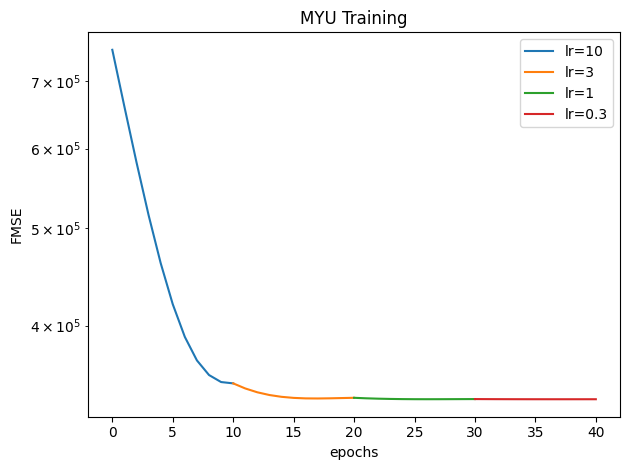

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

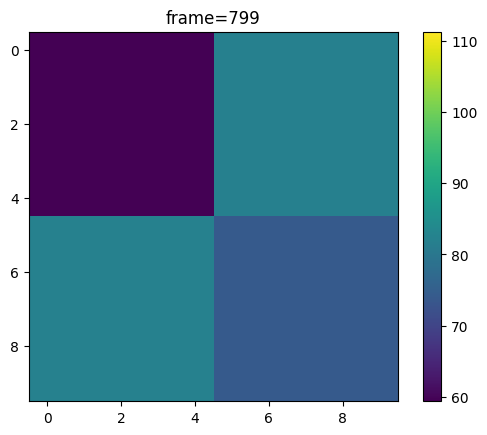

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

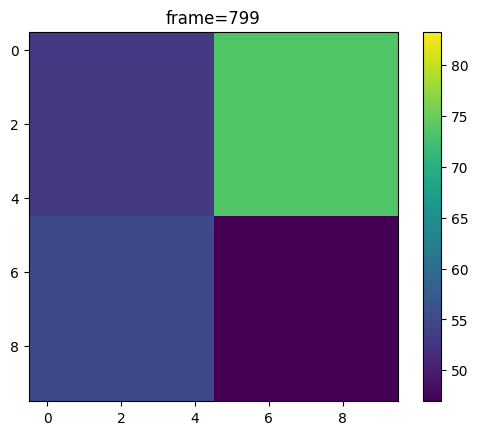

100%|██████████| 800/800 [00:41<00:00, 19.40it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=10L=40-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=10L=40-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8639.30it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600]
A.shape=(1, 800, 12, 12),
Myu.shape=(1, 800, 12, 12),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:57<00:00, 848.16it/s]


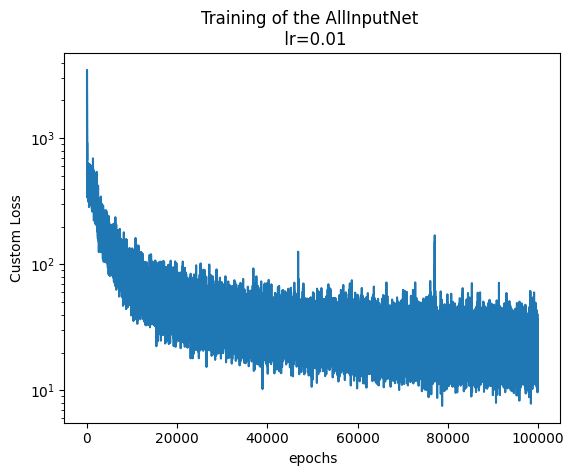

100%|██████████| 100000/100000 [01:58<00:00, 845.48it/s]


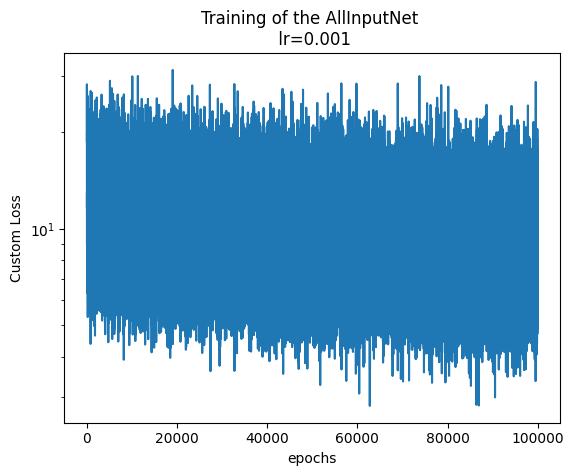

100%|██████████| 10/10 [00:00<00:00, 540.51it/s]


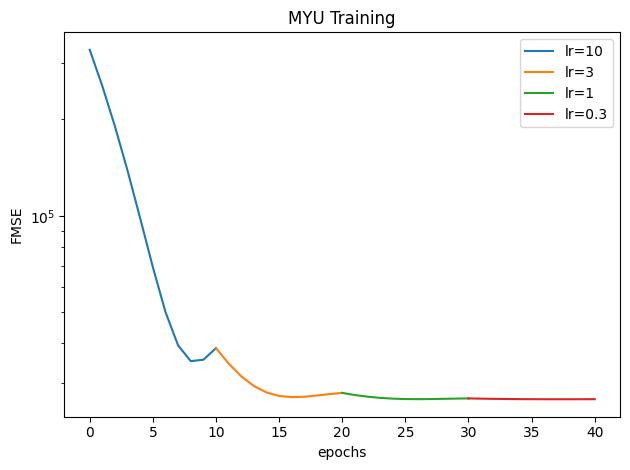

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

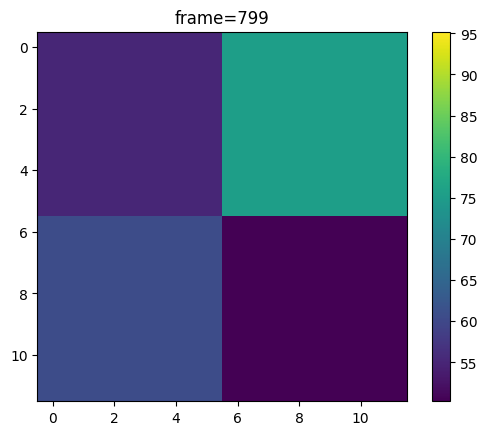

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

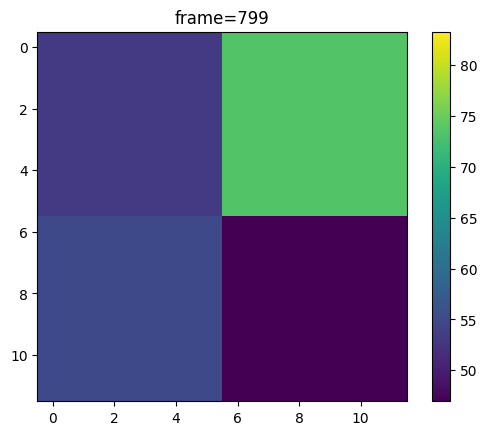

100%|██████████| 800/800 [00:42<00:00, 18.85it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=12L=10-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=12L=10-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8557.71it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600]
A.shape=(1, 800, 12, 12),
Myu.shape=(1, 800, 12, 12),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:58<00:00, 843.36it/s]


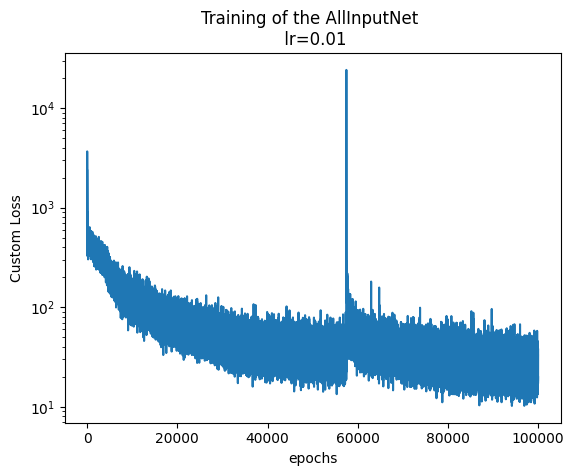

100%|██████████| 100000/100000 [01:59<00:00, 837.53it/s]


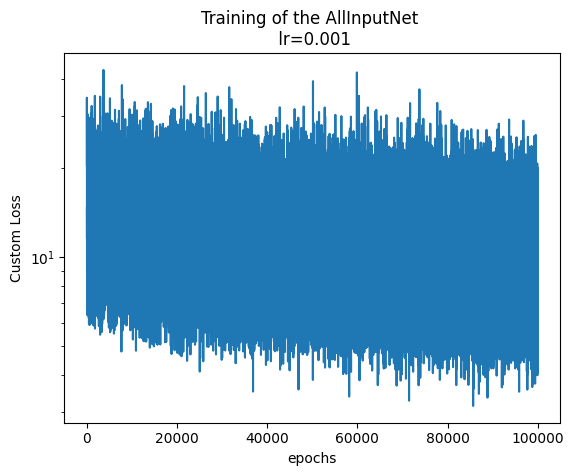

100%|██████████| 10/10 [00:00<00:00, 448.81it/s]


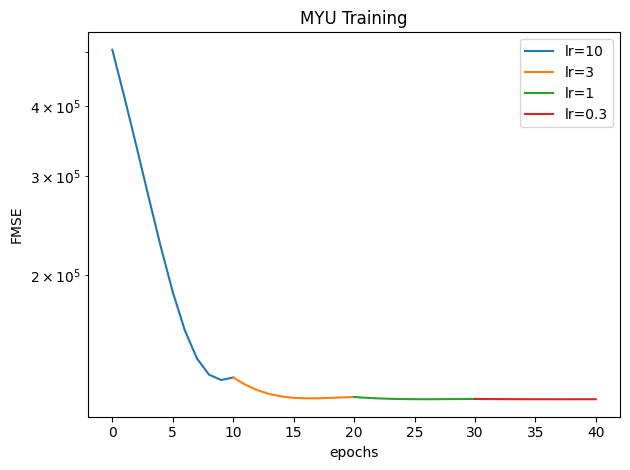

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

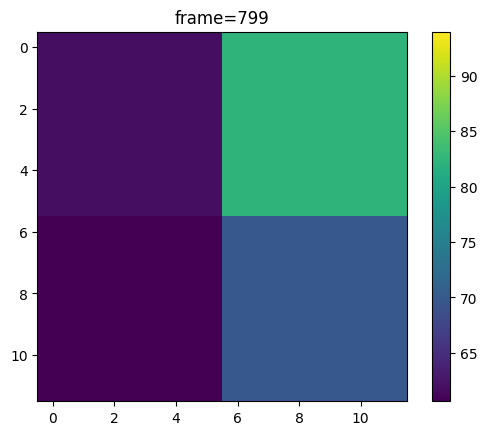

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

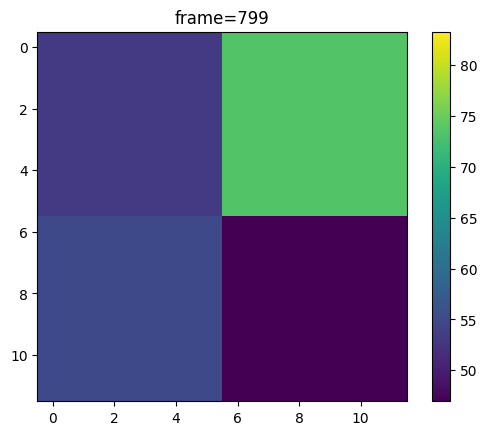

100%|██████████| 800/800 [00:42<00:00, 19.04it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=12L=20-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=12L=20-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8572.18it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600]
A.shape=(1, 800, 12, 12),
Myu.shape=(1, 800, 12, 12),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:59<00:00, 833.68it/s]


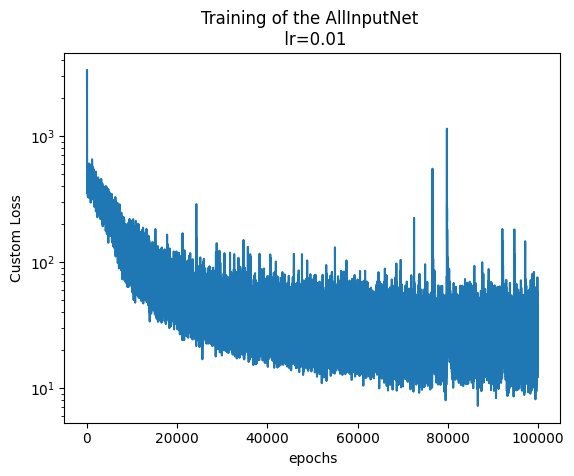

100%|██████████| 100000/100000 [01:58<00:00, 841.31it/s]


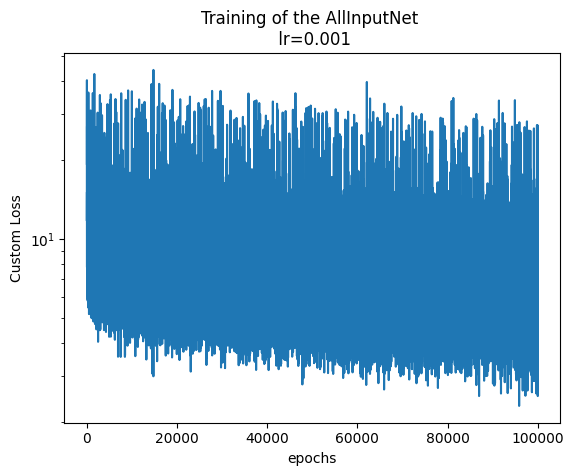

100%|██████████| 10/10 [00:00<00:00, 443.91it/s]


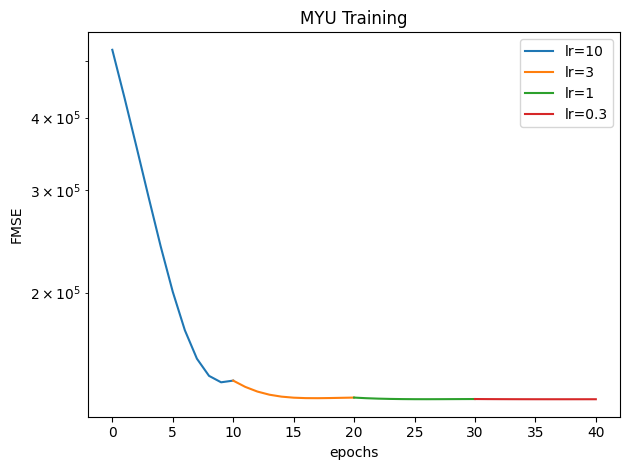

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

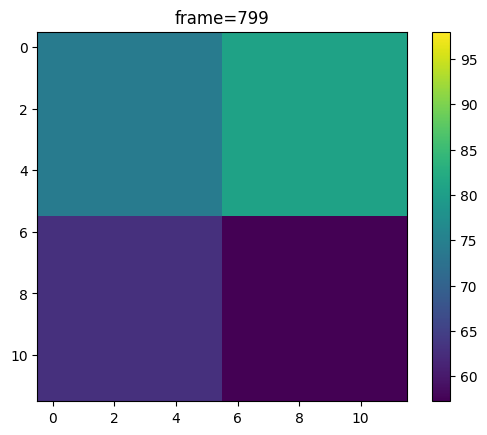

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

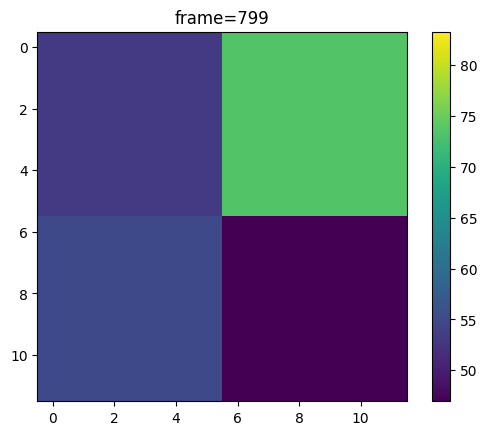

100%|██████████| 800/800 [00:42<00:00, 19.03it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=12L=30-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=12L=30-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 8667.66it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600 3600
 3600 3600 3600 3600]
A.shape=(1, 800, 12, 12),
Myu.shape=(1, 800, 12, 12),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:58<00:00, 846.15it/s]


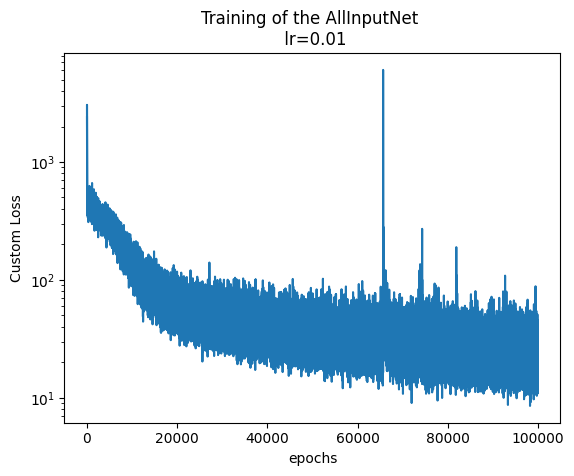

100%|██████████| 100000/100000 [01:57<00:00, 847.66it/s]


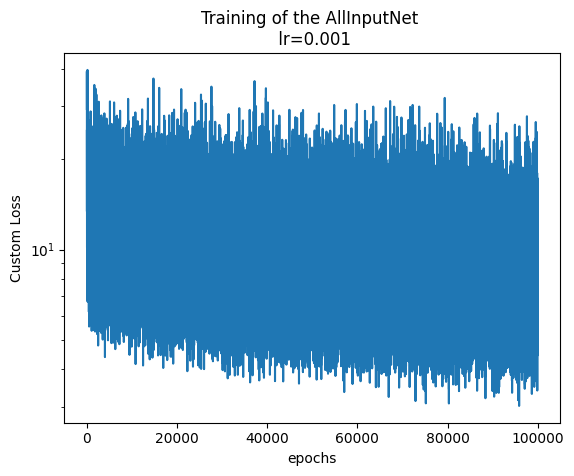

100%|██████████| 10/10 [00:00<00:00, 546.99it/s]


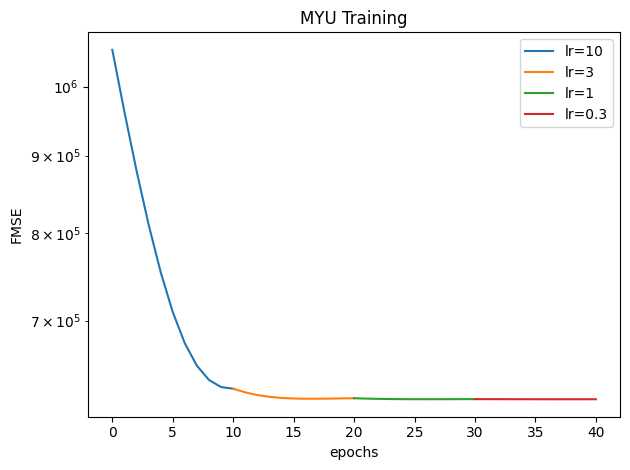

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

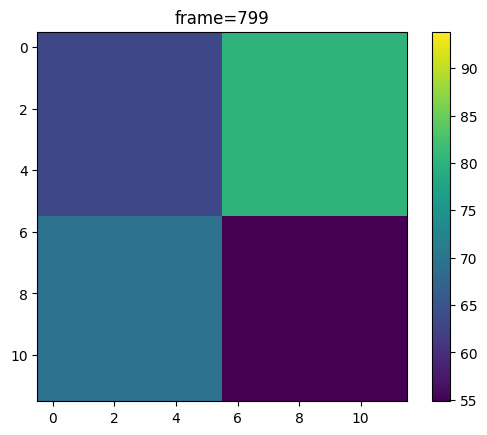

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

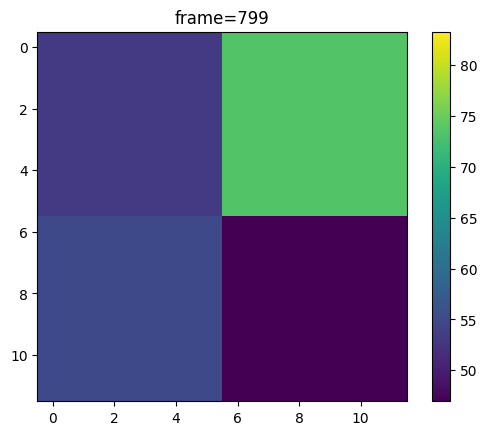

100%|██████████| 800/800 [00:42<00:00, 18.86it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=12L=40-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=12L=40-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 7542.19it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400]
A.shape=(1, 800, 16, 16),
Myu.shape=(1, 800, 16, 16),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:57<00:00, 853.26it/s]


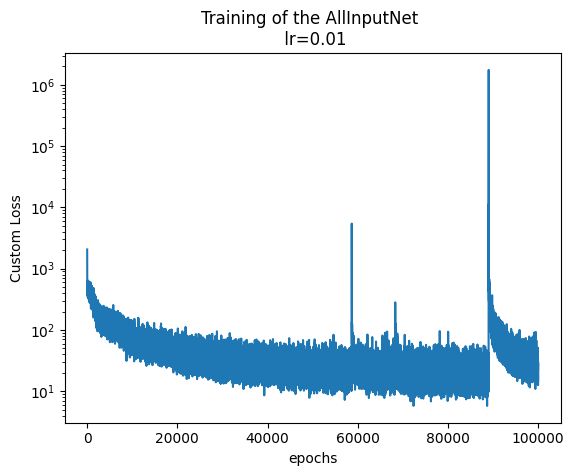

100%|██████████| 100000/100000 [01:57<00:00, 850.97it/s]


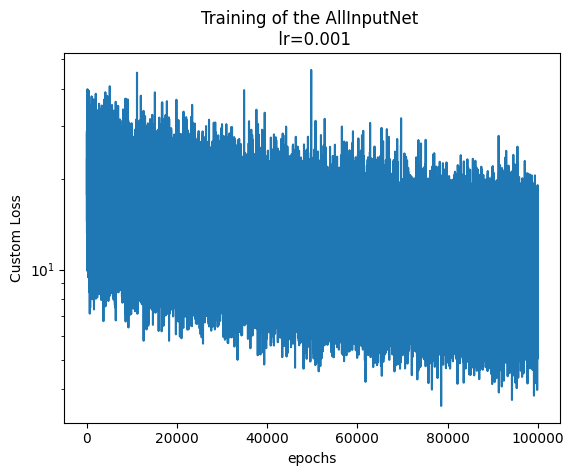

100%|██████████| 10/10 [00:00<00:00, 286.27it/s]


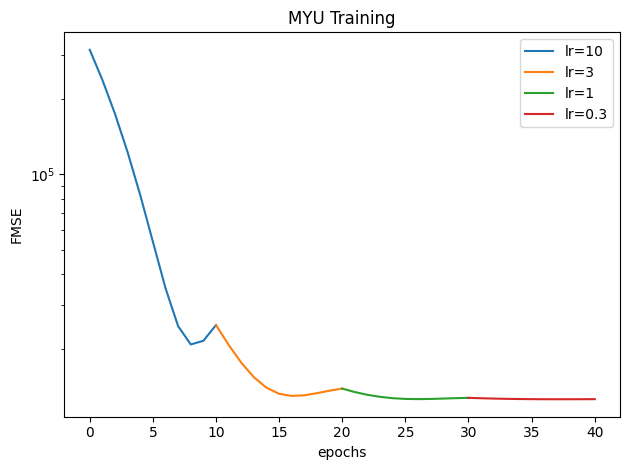

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

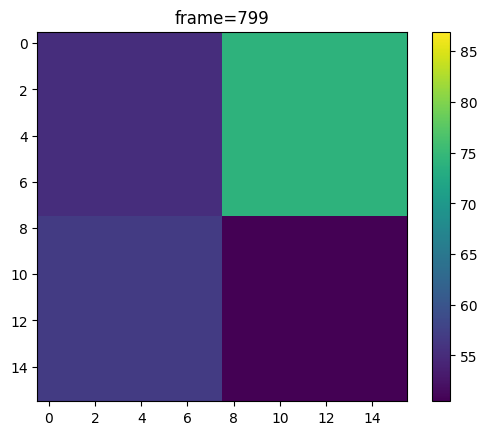

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

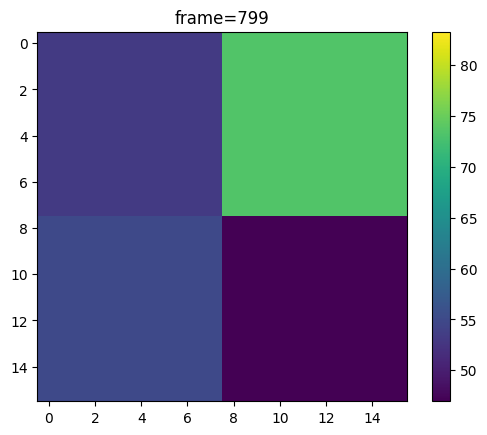

100%|██████████| 800/800 [00:45<00:00, 17.54it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=16L=10-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=16L=10-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 7665.24it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400]
A.shape=(1, 800, 16, 16),
Myu.shape=(1, 800, 16, 16),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:58<00:00, 845.35it/s]


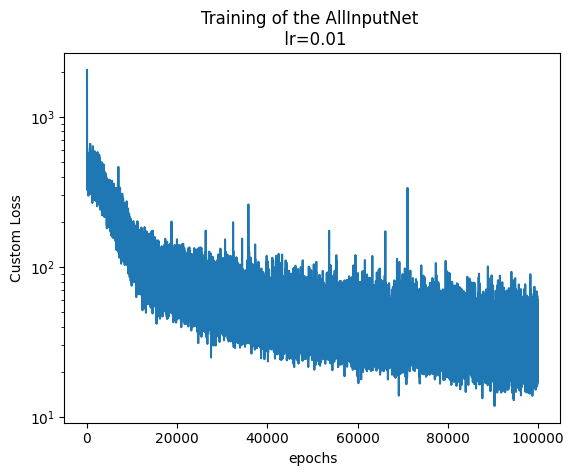

100%|██████████| 100000/100000 [01:59<00:00, 834.85it/s]


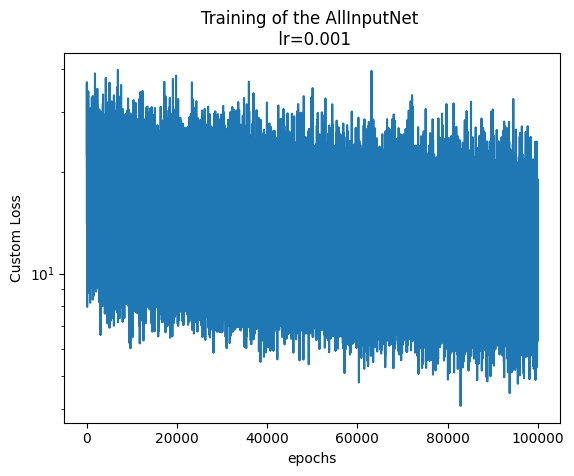

100%|██████████| 10/10 [00:00<00:00, 307.30it/s]


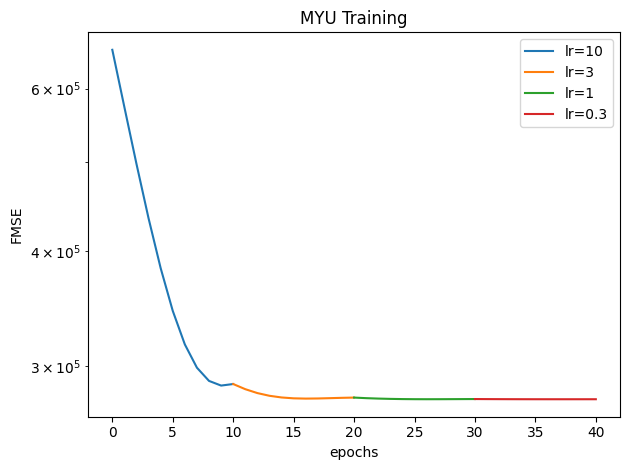

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

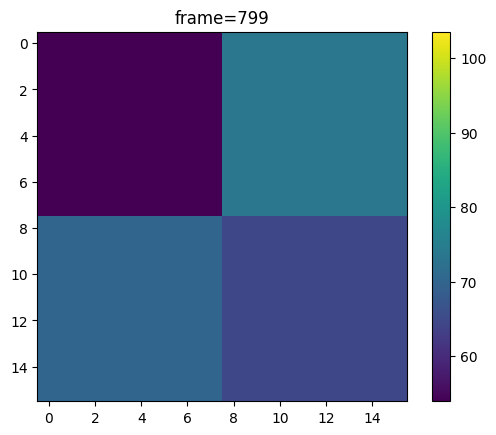

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

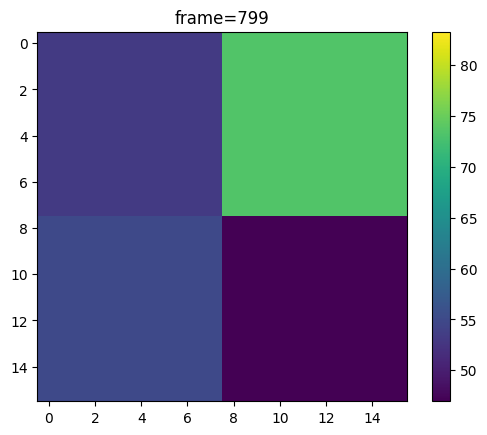

100%|██████████| 800/800 [00:45<00:00, 17.53it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=16L=20-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=16L=20-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 7467.41it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400]
A.shape=(1, 800, 16, 16),
Myu.shape=(1, 800, 16, 16),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:58<00:00, 845.77it/s]


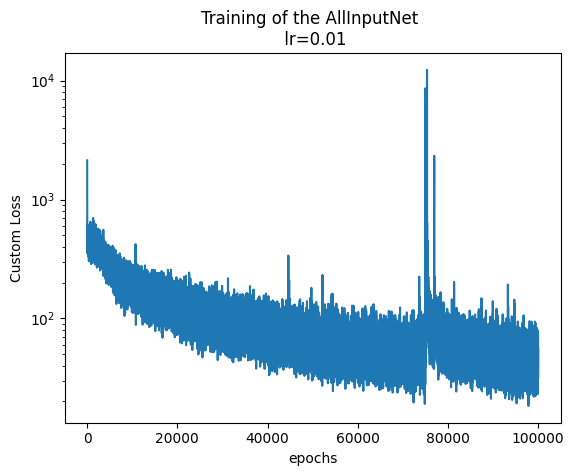

100%|██████████| 100000/100000 [01:58<00:00, 845.01it/s]


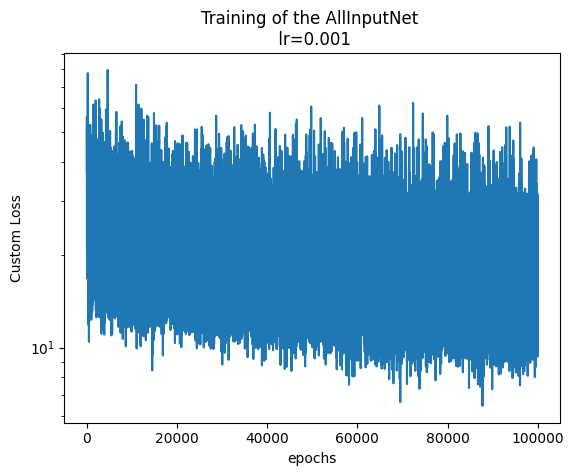

100%|██████████| 10/10 [00:00<00:00, 215.56it/s]


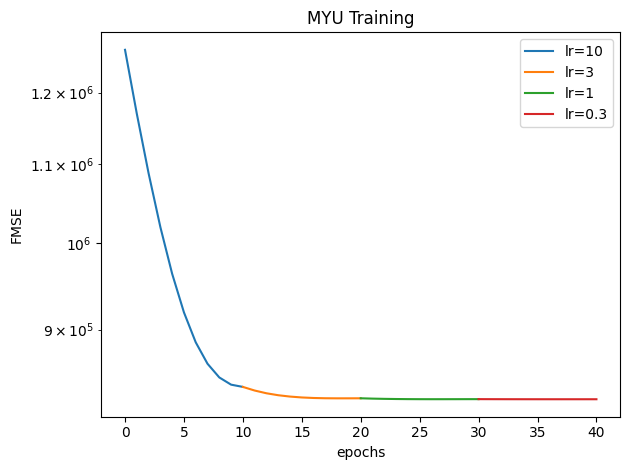

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

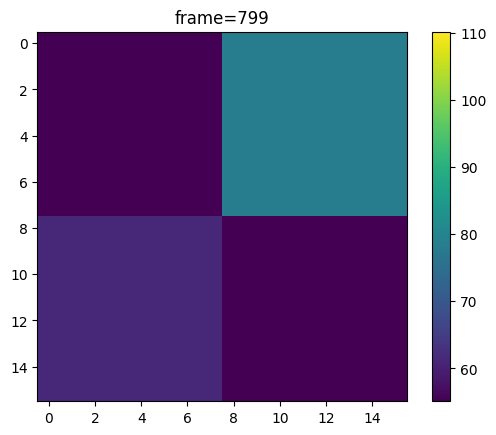

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

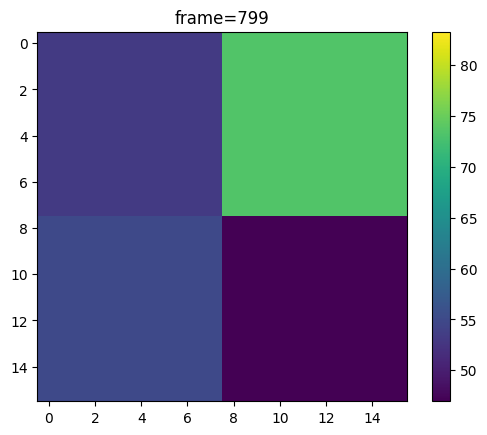

100%|██████████| 800/800 [00:45<00:00, 17.63it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=16L=30-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=16L=30-test2-origin.gif!


100%|██████████| 800/800 [00:00<00:00, 7631.56it/s]


Unique Myus count	 32
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 31.715187673074016, 35.60988308116816, 36.78037384559494, 41.379440591909756, 45.24593951725975, 46.940842460213354, 50.68938683112707, 52.148102201401514, 53.14903531323313, 53.20229459360476, 54.04546708767949, 54.95876970912288, 58.107982450278136, 62.084320595537484, 66.83168520679922, 67.11893941245006, 67.49308571672579, 67.95636271866604, 68.15148227223933, 73.33809836951713, 73.4242524130785, 74.53993910334896, 74.73071422581478, 80.75876026568818, 81.01192118026599, 81.40934487184863, 83.69288037425322, 85.47682436722725, 85.93150003649163, 93.14743245576308, 104.14104515595743]
Counts:		 [6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400]
A.shape=(1, 800, 16, 16),
Myu.shape=(1, 800, 16, 16),

Any NaN values in Myu		 False
Any NaN valu

100%|██████████| 100000/100000 [01:59<00:00, 837.12it/s]


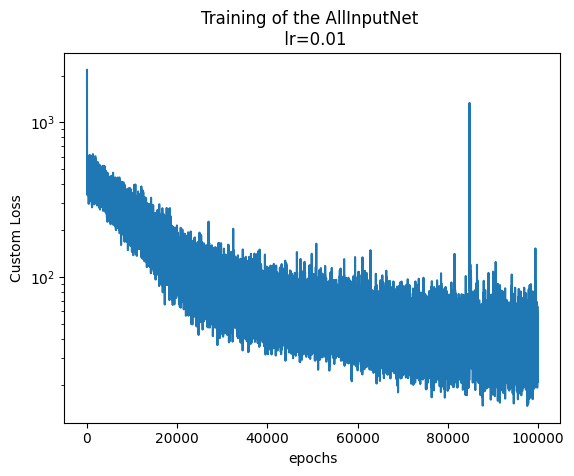

100%|██████████| 100000/100000 [01:58<00:00, 841.45it/s]


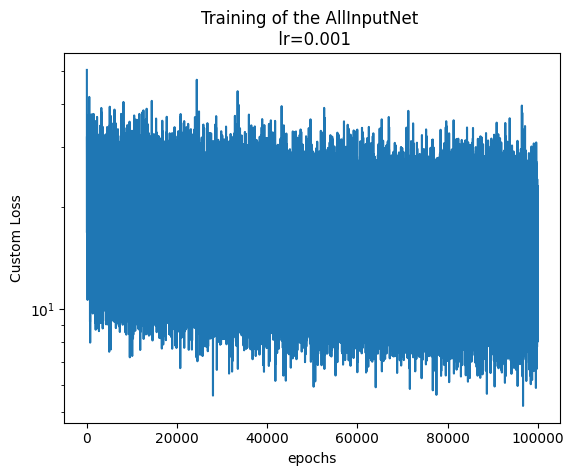

100%|██████████| 10/10 [00:00<00:00, 161.13it/s]


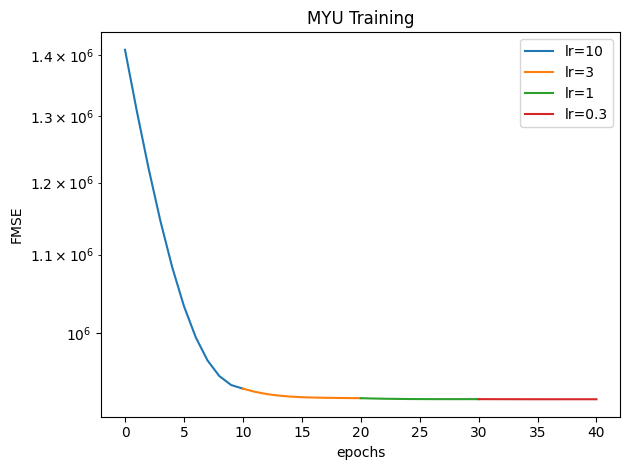

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

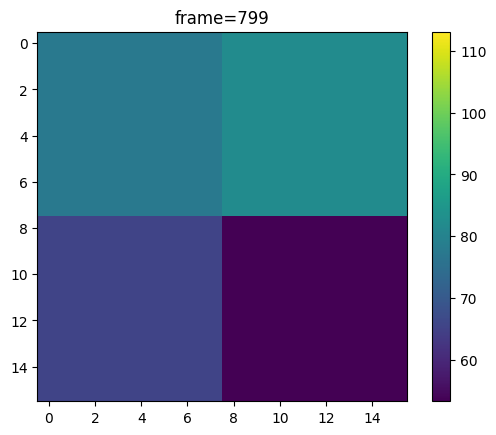

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

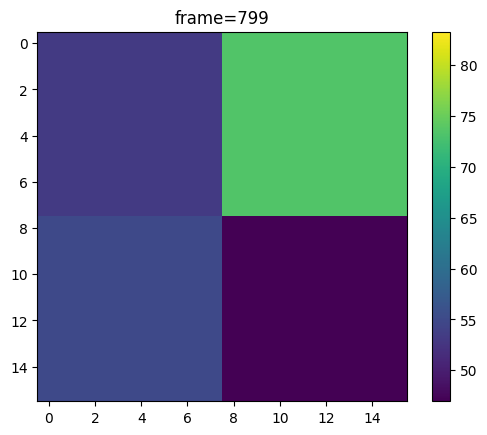

100%|██████████| 800/800 [00:45<00:00, 17.56it/s]


GIF successfully saved at main_lossanalysis/allinputnet-N=16L=40-test2-origin.gif
Total 400 frames in the gif main_lossanalysis/allinputnet-N=16L=40-test2-origin.gif!


In [10]:
N = 64
L = 60
rangeN = [4,10,12,16]
rangeL = [10,20,30,40]

for N in rangeN:
    for L in rangeL:
        key = f"N={N}L={L}-test2"
        path = f"main_lossanalysis/allinputnet-{key}-origin"
        mtlibpath_prefix =f"main_lossanalysis/allinputnet-{key}-origin_mtl"
        if key in set(df['key']):
            continue
            
        Nx=N
        Ny=N

        Lx= L
        Ly= L
        T_end = 4
        dt = 0.005

        input_to_defect_ratio_sqrt = N//2
        N_ITERATIONS = int(T_end / dt)
        A_norm, A_original, mem_rate, myu_original = compute_A_norm(
            Nx=Nx, 
            Ny=Ny, 
            input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
            mean=5.4, 
            std_deviation=0.8, 
            time_period=25, 
            Lx=Lx, 
            Ly=Ly, 
            dt=dt, 
            T_End=T_end, 
            parallel_runs=1, 
            input_scale=0.75, 
            mem_coef=1, 
            time_period_parameter=100, 
            _mean=5.4, 
            std_deviation_run_computation=1,
            input_myu=None
        )

        x = np.linspace(0, 4, Nx).flatten()[:, None] - 2
        y = np.linspace(0, 4, Ny).flatten()[:, None] - 2
        t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]
        Exact = A_original.squeeze(0)

        X, T, Y = np.meshgrid(x, t, y)

        X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
        u_star = Exact.flatten()
        u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

        torch.manual_seed(0)
        device = 'cpu'
        net = ALLINPUTPINN([3,8,32,64,32,8,2]).to(device)


        train()
        myutrain()
        plot()


        pred = net.predict(X_star)
        real = A_original.reshape(-1)        
        fmse = net.fmse().item()
        
        module = np.abs(pred-real)
        
        df = pd.concat([df,pd.DataFrame({"key":[key],"N":[N],"L":[L],"mse":[np.mean(module**2)],"rmse":[np.mean(module)],"fmse":[fmse]})])


In [11]:
df.to_csv("lossanalysisimproved.csv",index = False)

In [13]:
import pandas as pd
df = pd.read_csv("lossanalysisimproved.csv")

In [14]:
N = 64
L = 60
rangeN = [4,10,12,16]
rangeL = [10,20,30,40]
import numpy as np


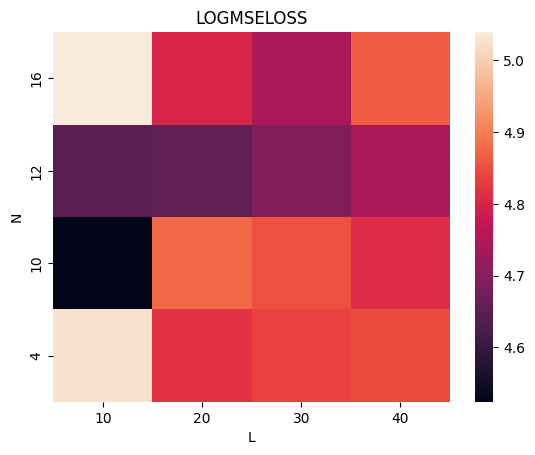

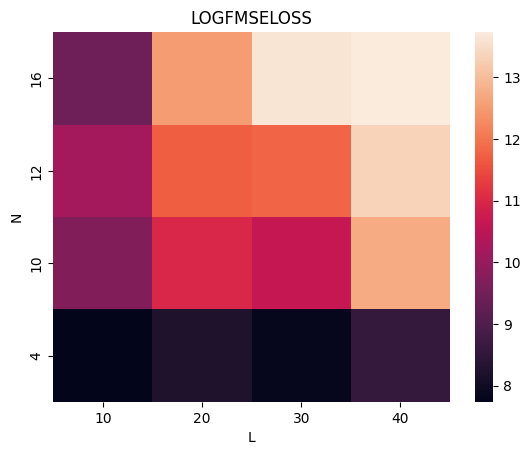

In [15]:
df = df.sort_values(by = ['N','L'])

yvals = rangeN
xvals = rangeL

zvals = np.log(np.array(np.array(df['mse'])).reshape(len(rangeN),len(rangeL)))
import seaborn as sns
import matplotlib.pyplot as plt
s = sns.heatmap(zvals,xticklabels = xvals,yticklabels = yvals)
s.set(xlabel='L', ylabel = 'N',title = "LOGMSELOSS")
plt.gca().invert_yaxis()
plt.savefig("LOGMSELOSSIMPROVED.png")
plt.show()

yvals = rangeN
xvals = rangeL

zvals = np.log(np.array(df['fmse']).reshape(len(rangeN),len(rangeL)))

s = sns.heatmap(zvals,xticklabels = xvals,yticklabels = yvals)
s.set(xlabel='L', ylabel = 'N',title = "LOGFMSELOSS")
plt.gca().invert_yaxis()
plt.savefig("LOGFMSELOSSIMPROVED.png")
plt.show()
